# Synthetic Data Gamma Scalping Simulation
## Testing gamma scalping strategies with GBM and Stochastic Volatility models

This notebook simulates gamma scalping strategies using synthetic price paths from:
1. Geometric Brownian Motion (GBM) - constant volatility
2. Heston Model - stochastic volatility with mean reversion
3. SABR Model - stochastic volatility with volatility smile

This allows us to test strategies in controlled environments with known parameters.

In [1]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.optimize import minimize, brentq
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))

# Import our modules
from models.options_pricing import bs_price, delta, gamma, theta, vega, implied_volatility
from simulation.gamma_scalping_simulator import GammaScalpingSimulator, GammaScalpingResult

# Set random seed for reproducibility
np.random.seed(42)

print("📊 Synthetic Gamma Scalping Simulation")
print("✅ Libraries loaded successfully!")

📊 Synthetic Gamma Scalping Simulation
✅ Libraries loaded successfully!


## 1. Geometric Brownian Motion (GBM) Simulation

The GBM model assumes:
- Constant volatility
- Log-normal price distribution
- No jumps or extreme events

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

In [2]:
def generate_gbm_paths(
    S0: float,
    mu: float,
    sigma: float,
    T: float,
    dt: float,
    n_paths: int = 1
) -> np.ndarray:
    """
    Generate GBM price paths using exact simulation.
    
    Args:
        S0: Initial price
        mu: Drift rate (annualized)
        sigma: Volatility (annualized)
        T: Time horizon in years
        dt: Time step in years (e.g., 1/365 for daily)
        n_paths: Number of paths to simulate
        
    Returns:
        Array of shape (n_steps+1, n_paths) with price paths
    """
    n_steps = int(T / dt)
    
    # Generate random shocks
    Z = np.random.standard_normal((n_steps, n_paths))
    
    # Initialize price array
    S = np.zeros((n_steps + 1, n_paths))
    S[0] = S0
    
    # Generate paths using exact GBM solution
    for t in range(1, n_steps + 1):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
    
    return S

# Test GBM generation
test_params = {
    'S0': 100,
    'mu': 0.05,  # 5% drift
    'sigma': 0.30,  # 30% volatility
    'T': 30/365,  # 30 days
    'dt': 1/365/24,  # Hourly steps
    'n_paths': 5
}

gbm_paths = generate_gbm_paths(**test_params)
print(f"Generated {gbm_paths.shape[1]} GBM paths with {gbm_paths.shape[0]} time steps")
print(f"Price range: ${gbm_paths.min():.2f} - ${gbm_paths.max():.2f}")

Generated 5 GBM paths with 721 time steps
Price range: $95.45 - $123.74


## 2. Heston Stochastic Volatility Model

The Heston model includes stochastic volatility with mean reversion:

$$dS_t = \mu S_t dt + \sqrt{V_t} S_t dW_t^S$$
$$dV_t = \kappa(\theta - V_t)dt + \xi \sqrt{V_t} dW_t^V$$
$$dW_t^S \cdot dW_t^V = \rho dt$$

In [3]:
def generate_heston_paths(
    S0: float,
    V0: float,
    mu: float,
    kappa: float,
    theta: float,
    xi: float,
    rho: float,
    T: float,
    dt: float,
    n_paths: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate Heston model paths using Euler-Milstein scheme.
    
    Args:
        S0: Initial price
        V0: Initial variance
        mu: Drift rate
        kappa: Mean reversion speed for variance
        theta: Long-term variance level
        xi: Volatility of variance
        rho: Correlation between price and variance
        T: Time horizon
        dt: Time step
        n_paths: Number of paths
        
    Returns:
        Tuple of (price_paths, variance_paths)
    """
    n_steps = int(T / dt)
    
    # Initialize arrays
    S = np.zeros((n_steps + 1, n_paths))
    V = np.zeros((n_steps + 1, n_paths))
    S[0] = S0
    V[0] = V0
    
    # Generate correlated Brownian motions
    Z1 = np.random.standard_normal((n_steps, n_paths))
    Z2 = np.random.standard_normal((n_steps, n_paths))
    W_S = Z1
    W_V = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    
    # Simulate paths
    for t in range(1, n_steps + 1):
        # Ensure variance stays positive (truncation scheme)
        V_pos = np.maximum(V[t-1], 0)
        
        # Update variance (Milstein scheme)
        dV = kappa * (theta - V_pos) * dt + xi * np.sqrt(V_pos * dt) * W_V[t-1]
        V[t] = V[t-1] + dV + 0.25 * xi**2 * dt * (W_V[t-1]**2 - 1)
        V[t] = np.maximum(V[t], 0)  # Ensure non-negative
        
        # Update price
        S[t] = S[t-1] * np.exp((mu - 0.5 * V_pos) * dt + np.sqrt(V_pos * dt) * W_S[t-1])
    
    return S, V

# Test Heston generation
heston_params = {
    'S0': 100,
    'V0': 0.04,  # Initial variance (20% vol)
    'mu': 0.05,
    'kappa': 2.0,  # Mean reversion speed
    'theta': 0.04,  # Long-term variance (20% vol)
    'xi': 0.3,  # Vol of vol
    'rho': -0.5,  # Negative correlation (leverage effect)
    'T': 30/365,
    'dt': 1/365/24,
    'n_paths': 5
}

heston_S, heston_V = generate_heston_paths(**heston_params)
print(f"Generated Heston paths: S shape {heston_S.shape}, V shape {heston_V.shape}")
print(f"Volatility range: {np.sqrt(heston_V).min():.1%} - {np.sqrt(heston_V).max():.1%}")

Generated Heston paths: S shape (721, 5), V shape (721, 5)
Volatility range: 17.1% - 27.8%


## 3. SABR Model

The SABR model is particularly useful for interest rates and FX, capturing volatility smile:

$$dF_t = \alpha_t F_t^\beta dW_t^F$$
$$d\alpha_t = \nu \alpha_t dW_t^\alpha$$
$$dW_t^F \cdot dW_t^\alpha = \rho dt$$

In [4]:
def generate_sabr_paths(
    F0: float,
    alpha0: float,
    beta: float,
    nu: float,
    rho: float,
    T: float,
    dt: float,
    n_paths: int = 1
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate SABR model paths.
    
    Args:
        F0: Initial forward price
        alpha0: Initial volatility
        beta: CEV parameter (0=normal, 1=lognormal)
        nu: Volatility of volatility
        rho: Correlation
        T: Time horizon
        dt: Time step
        n_paths: Number of paths
        
    Returns:
        Tuple of (forward_paths, volatility_paths)
    """
    n_steps = int(T / dt)
    
    # Initialize arrays
    F = np.zeros((n_steps + 1, n_paths))
    alpha = np.zeros((n_steps + 1, n_paths))
    F[0] = F0
    alpha[0] = alpha0
    
    # Generate correlated Brownian motions
    Z1 = np.random.standard_normal((n_steps, n_paths))
    Z2 = np.random.standard_normal((n_steps, n_paths))
    W_F = Z1
    W_alpha = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    
    # Simulate paths
    for t in range(1, n_steps + 1):
        # Update volatility (lognormal)
        alpha[t] = alpha[t-1] * np.exp(-0.5 * nu**2 * dt + nu * np.sqrt(dt) * W_alpha[t-1])
        
        # Update forward price
        if beta == 1:  # Lognormal case
            F[t] = F[t-1] * np.exp(-0.5 * alpha[t-1]**2 * dt + alpha[t-1] * np.sqrt(dt) * W_F[t-1])
        else:  # General CEV case
            # Use Milstein scheme for better accuracy
            F_pow = np.maximum(F[t-1], 0.01) ** beta  # Avoid numerical issues
            dF = alpha[t-1] * F_pow * np.sqrt(dt) * W_F[t-1]
            dF2 = 0.5 * alpha[t-1]**2 * beta * F_pow * (F_pow / F[t-1]) * dt * (W_F[t-1]**2 - 1)
            F[t] = F[t-1] + dF + dF2
            F[t] = np.maximum(F[t], 0.01)  # Keep positive
    
    return F, alpha

# Test SABR generation
sabr_params = {
    'F0': 100,
    'alpha0': 0.25,  # Initial vol
    'beta': 0.7,  # Between normal and lognormal
    'nu': 0.4,  # Vol of vol
    'rho': -0.3,  # Negative correlation
    'T': 30/365,
    'dt': 1/365/24,
    'n_paths': 5
}

sabr_F, sabr_alpha = generate_sabr_paths(**sabr_params)
print(f"Generated SABR paths: F shape {sabr_F.shape}, alpha shape {sabr_alpha.shape}")
print(f"Forward price range: ${sabr_F.min():.2f} - ${sabr_F.max():.2f}")
print(f"Volatility range: {sabr_alpha.min():.1%} - {sabr_alpha.max():.1%}")

Generated SABR paths: F shape (721, 5), alpha shape (721, 5)
Forward price range: $96.63 - $102.88
Volatility range: 20.8% - 30.5%


## 4. Option Pricing for Synthetic Data

We'll create synthetic option prices that are consistent with the underlying model.

In [5]:
def create_synthetic_option_data(
    spot_path: np.ndarray,
    strike: float,
    expiry: float,
    vol_path: Optional[np.ndarray] = None,
    constant_vol: float = 0.30,
    risk_free_rate: float = 0.01,
    option_type: str = 'call',
    dt: float = 1/365/24
) -> pd.DataFrame:
    """
    Create synthetic option data consistent with the spot path.
    
    Args:
        spot_path: Array of spot prices
        strike: Option strike price
        expiry: Time to expiry in years
        vol_path: Optional array of volatilities (for SV models)
        constant_vol: Volatility to use if vol_path not provided
        risk_free_rate: Risk-free rate
        option_type: 'call' or 'put'
        dt: Time step
        
    Returns:
        DataFrame with synthetic option data
    """
    n_steps = len(spot_path)
    
    # Create timestamps
    timestamps = pd.date_range(start='2024-01-01', periods=n_steps, freq='h')
    expiry_date = timestamps[0] + pd.Timedelta(days=int(expiry * 365))
    
    # Calculate time to expiry for each step
    tte = np.array([(expiry_date - t).total_seconds() / (365 * 24 * 3600) 
                    for t in timestamps])
    tte = np.maximum(tte, 0)
    
    # Use provided volatility path or constant
    if vol_path is not None:
        vols = vol_path
    else:
        vols = np.full(n_steps, constant_vol)
    
    # Calculate option prices
    option_prices = []
    for i in range(n_steps):
        if tte[i] > 0:
            price = bs_price(spot_path[i], strike, tte[i], risk_free_rate, vols[i], option_type)
        else:
            # At expiry
            if option_type == 'call':
                price = max(spot_path[i] - strike, 0)
            else:
                price = max(strike - spot_path[i], 0)
        option_prices.append(price)
    
    # Create DataFrame
    option_data = pd.DataFrame({
        'timestamp': timestamps,
        'strike': strike,
        'expiry': expiry_date,
        'option_type': option_type,
        'close': option_prices,
        'implied_vol': vols,
        'volume': 1000,  # Dummy volume
        'open_interest': 10000  # Dummy OI
    })
    
    # Create spot data DataFrame
    spot_data = pd.DataFrame({
        'timestamp': timestamps,
        'close': spot_path
    })
    
    return spot_data, option_data

# Create synthetic option data for GBM path
gbm_spot = gbm_paths[:, 0]  # Take first path
gbm_spot_df, gbm_option_df = create_synthetic_option_data(
    spot_path=gbm_spot,
    strike=100,  # ATM
    expiry=30/365,
    constant_vol=0.30,
    option_type='call'
)

print(f"Created synthetic option data:")
print(f"  Spot prices: {len(gbm_spot_df)} points")
print(f"  Option prices: {len(gbm_option_df)} points")
print(f"  Option price range: ${gbm_option_df['close'].min():.2f} - ${gbm_option_df['close'].max():.2f}")

Created synthetic option data:
  Spot prices: 721 points
  Option prices: 721 points
  Option price range: $1.48 - $8.58


<Axes: title={'center': 'Synthetic GBM Spot Prices'}, ylabel='Spot Price ($)'>

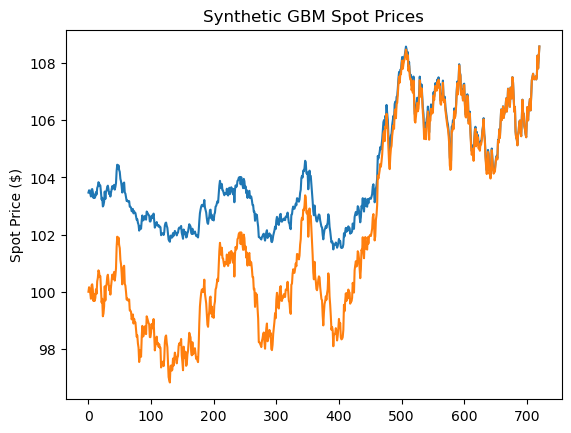

In [6]:
(gbm_option_df.close + 100).plot(title="Synthetic GBM Option Prices", ylabel="Option Price ($)")
gbm_spot_df.close.plot(title="Synthetic GBM Spot Prices", ylabel="Spot Price ($)")

In [7]:
comission_rate = 0
slippage_bps = 0

In [8]:
def run_monte_carlo_simulation_fast(
    model_type: str = "GBM",
    n_paths: int = 100,
    use_parallel: bool = True,
    **model_params
) -> Dict:
    """
    Fast Monte Carlo simulation using vectorized path generation
    but keeping the original hedging simulator for accuracy.
    
    Args:
        model_type: "GBM", "Heston", or "SABR"
        n_paths: Number of paths to simulate
        use_parallel: Whether to use parallel processing
        **model_params: Parameters for the specific model
        
    Returns:
        Dictionary with statistics
    """
    import time
    from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
    import multiprocessing as mp
    
    # Common parameters
    S0 = model_params.get('S0', 100)
    strike = model_params.get('strike', 100)
    mu = model_params.get('mu', 0.05)
    T = model_params.get('T', 30/365)
    dt = model_params.get('dt', 1/365/24)
    hedge_threshold = model_params.get('hedge_threshold', 0.05)
    n_steps = int(T / dt)
    
    print(f"🎲 Running Fast Monte Carlo with {n_paths} paths for {model_type}...")
    if use_parallel:
        print(f"   Using parallel processing with {mp.cpu_count()} cores")
    start_time = time.time()
    
    # STEP 1: Vectorized path generation for ALL paths at once
    if model_type == "GBM":
        sigma = model_params.get('sigma', 0.30)
        
        # Generate all random numbers at once
        Z = np.random.standard_normal((n_steps, n_paths))
        S_all = np.zeros((n_steps + 1, n_paths))
        S_all[0] = S0
        
        # Vectorized GBM calculation
        for t in range(1, n_steps + 1):
            S_all[t] = S_all[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
        
        vol_paths = np.full((n_steps + 1, n_paths), sigma)
        
    elif model_type == "Heston":
        V0 = model_params.get('V0', 0.09)
        kappa = model_params.get('kappa', 2.0)
        theta = model_params.get('theta', 0.09)
        xi = model_params.get('xi', 0.3)
        rho = model_params.get('rho', -0.5)
        
        # Generate correlated Brownian motions for all paths at once
        Z1 = np.random.standard_normal((n_steps, n_paths))
        Z2 = np.random.standard_normal((n_steps, n_paths))
        W_S = Z1
        W_V = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        
        S_all = np.zeros((n_steps + 1, n_paths))
        V_all = np.zeros((n_steps + 1, n_paths))
        S_all[0] = S0
        V_all[0] = V0
        
        # Vectorized Heston simulation
        for t in range(1, n_steps + 1):
            V_pos = np.maximum(V_all[t-1], 0)
            dV = kappa * (theta - V_pos) * dt + xi * np.sqrt(V_pos * dt) * W_V[t-1]
            V_all[t] = V_all[t-1] + dV + 0.25 * xi**2 * dt * (W_V[t-1]**2 - 1)
            V_all[t] = np.maximum(V_all[t], 0)
            S_all[t] = S_all[t-1] * np.exp((mu - 0.5 * V_pos) * dt + np.sqrt(V_pos * dt) * W_S[t-1])
        
        vol_paths = np.sqrt(V_all)
        
    elif model_type == "SABR":
        alpha0 = model_params.get('alpha0', 0.25)
        beta = model_params.get('beta', 0.7)
        nu = model_params.get('nu', 0.4)
        rho = model_params.get('rho', -0.3)
        
        Z1 = np.random.standard_normal((n_steps, n_paths))
        Z2 = np.random.standard_normal((n_steps, n_paths))
        W_F = Z1
        W_alpha = rho * Z1 + np.sqrt(1 - rho**2) * Z2
        
        S_all = np.zeros((n_steps + 1, n_paths))
        alpha_all = np.zeros((n_steps + 1, n_paths))
        S_all[0] = S0
        alpha_all[0] = alpha0
        
        for t in range(1, n_steps + 1):
            alpha_all[t] = alpha_all[t-1] * np.exp(-0.5 * nu**2 * dt + nu * np.sqrt(dt) * W_alpha[t-1])
            
            if beta == 1:
                S_all[t] = S_all[t-1] * np.exp(-0.5 * alpha_all[t-1]**2 * dt + alpha_all[t-1] * np.sqrt(dt) * W_F[t-1])
            else:
                F_pow = np.maximum(S_all[t-1], 0.01) ** beta
                dF = alpha_all[t-1] * F_pow * np.sqrt(dt) * W_F[t-1]
                dF2 = 0.5 * alpha_all[t-1]**2 * beta * F_pow * (F_pow / S_all[t-1]) * dt * (W_F[t-1]**2 - 1)
                S_all[t] = S_all[t-1] + dF + dF2
                S_all[t] = np.maximum(S_all[t], 0.01)
        
        vol_paths = alpha_all
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    print(f"✅ Path generation complete ({time.time() - start_time:.2f}s)")
    
    # STEP 2: Run the original simulator for each path
    def simulate_single_path(path_idx):
        """Helper function to simulate a single path using the original simulator."""
        # Extract the path for this simulation
        spot_path = S_all[:, path_idx]
        vol_path = vol_paths[:, path_idx] if vol_paths is not None else None
        
        # Create synthetic option data for this path
        spot_df, option_df = create_synthetic_option_data(
            spot_path=spot_path,
            strike=strike,
            expiry=T,
            vol_path=vol_path,
            constant_vol=model_params.get('sigma', 0.30) if model_type == "GBM" else None,
            option_type='call',
            dt=dt
        )
        
        # Run the original gamma scalping simulator
        simulator = GammaScalpingSimulator(
            commission_rate=model_params.get('commission_rate', 0),
            slippage_bps=model_params.get('slippage_bps', 0),
            risk_free_rate=mu
        )
        
        result = simulator.simulate(
            spot_df, option_df, hedge_threshold, 1.0
        )
        
        if result:
            return {
                'total_pnl': result.total_pnl,
                'option_pnl': result.option_pnl,
                'hedge_pnl': result.hedge_pnl,
                'num_hedges': result.num_hedges,
                'gamma_pnl': result.total_gamma_pnl,
                'theta_cost': result.total_theta_cost
            }
        return None
    
    # Run simulations either in parallel or sequentially
    simulation_start = time.time()
    
    if use_parallel and n_paths > 10:
        # Use parallel processing for large number of paths
        max_workers = min(mp.cpu_count(), n_paths, 8)  # Limit to 8 workers
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all tasks
            futures = [executor.submit(simulate_single_path, i) for i in range(n_paths)]
            
            # Collect results with progress bar
            from tqdm import tqdm
            results = []
            for future in tqdm(futures, desc="Simulating paths"):
                result = future.result()
                if result:
                    results.append(result)
    else:
        # Sequential processing
        from tqdm import tqdm
        results = []
        for i in tqdm(range(n_paths), desc="Simulating paths"):
            result = simulate_single_path(i)
            if result:
                results.append(result)
    
    print(f"✅ Simulation complete ({time.time() - simulation_start:.2f}s)")
    
    # STEP 3: Aggregate results
    if not results:
        raise ValueError("No valid simulation results")
    
    # Extract P&L array and other metrics
    pnl_array = np.array([r['total_pnl'] for r in results])
    option_pnls = [r['option_pnl'] for r in results]
    hedge_pnls = [r['hedge_pnl'] for r in results]
    num_hedges = [r['num_hedges'] for r in results]
    gamma_pnls = [r['gamma_pnl'] for r in results]
    theta_costs = [r['theta_cost'] for r in results]
    
    # Calculate statistics
    elapsed_time = time.time() - start_time
    
    stats = {
        'model': model_type,
        'n_paths': n_paths,
        'computation_time': elapsed_time,
        'mean_pnl': np.mean(pnl_array),
        'std_pnl': np.std(pnl_array),
        'min_pnl': np.min(pnl_array),
        'max_pnl': np.max(pnl_array),
        'percentile_5': np.percentile(pnl_array, 5),
        'percentile_25': np.percentile(pnl_array, 25),
        'median_pnl': np.median(pnl_array),
        'percentile_75': np.percentile(pnl_array, 75),
        'percentile_95': np.percentile(pnl_array, 95),
        'win_rate': np.mean(pnl_array > 0),
        'sharpe_ratio': np.mean(pnl_array) / np.std(pnl_array) if np.std(pnl_array) > 0 else 0,
        'mean_option_pnl': np.mean(option_pnls),
        'mean_hedge_pnl': np.mean(hedge_pnls),
        'mean_num_hedges': np.mean(num_hedges),
        'mean_gamma_pnl': np.mean(gamma_pnls),
        'mean_theta_cost': np.mean(theta_costs),
        'pnl_results': pnl_array
    }
    
    print(f"✅ Total time: {elapsed_time:.2f}s ({n_paths/elapsed_time:.0f} paths/second)")
    print(f"📊 Results: Mean P&L=${stats['mean_pnl']:.2f}, Win Rate={stats['win_rate']:.1%}")
    
    return stats

# Test the fast Monte Carlo with original simulator
print("🚀 Testing Fast Monte Carlo with Original Hedging Simulator\n")
print("="*60)

# Small test first
fast_results_small = run_monte_carlo_simulation_fast(
    model_type="GBM",
    n_paths=100,
    sigma=0.30,
    mu=0.05,
    T=30/365,
    dt=1/365/24,
    use_parallel=True
)

print(f"\n📊 Fast MC Results (100 paths):")
print(f"  Mean P&L: ${fast_results_small['mean_pnl']:.2f}")
print(f"  Std Dev: ${fast_results_small['std_pnl']:.2f}")
print(f"  Win Rate: {fast_results_small['win_rate']:.1%}")
print(f"  Sharpe Ratio: {fast_results_small['sharpe_ratio']:.3f}")

🚀 Testing Fast Monte Carlo with Original Hedging Simulator

🎲 Running Fast Monte Carlo with 100 paths for GBM...
   Using parallel processing with 14 cores
✅ Path generation complete (0.00s)


Simulating paths: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]

✅ Simulation complete (51.15s)
✅ Total time: 51.15s (2 paths/second)
📊 Results: Mean P&L=$-0.08, Win Rate=51.0%

📊 Fast MC Results (100 paths):
  Mean P&L: $-0.08
  Std Dev: $0.56
  Win Rate: 51.0%
  Sharpe Ratio: -0.140


In [9]:
mc_results = {}
mc_results['fast_gbm_100'] = fast_results_small

In [10]:
# Run Monte Carlo for different models
mc_results['GBM_15'] = run_monte_carlo_simulation(
    model_type="GBM",
    n_paths=100,
    sigma=0.15,
    mu=0.05
)

mc_results['GBM_45'] = run_monte_carlo_simulation(
    model_type="GBM",
    n_paths=100,
    sigma=0.45,
    mu=0.05
)

mc_results['Heston'] = run_monte_carlo_simulation(
    model_type="Heston",
    n_paths=100,
    V0=0.09,
    kappa=2.0,
    theta=0.09,
    xi=0.3,
    rho=-0.5
)

mc_results['SABR'] = run_monte_carlo_simulation(
    model_type="SABR",
    n_paths=100,
    alpha0=0.25,
    beta=0.7,
    nu=0.4,
    rho=-0.3
)

# Print comprehensive statistics
print("\n📊 Monte Carlo Results Summary")
print("="*70)
print(f"{'Model':<15} {'Mean P&L':<12} {'Std Dev':<10} {'Win Rate':<10} {'Sharpe':<10}")
print("-"*70)

for name, stats in mc_results.items():
    print(f"{name:<15} ${stats['mean_pnl']:>10.2f} ${stats['std_pnl']:>8.2f} {stats['win_rate']:>8.1%} {stats['sharpe_ratio']:>9.3f}")

print("\n📊 Percentile Analysis")
print("="*70)
print(f"{'Model':<15} {'5%':<12} {'25%':<12} {'Median':<12} {'75%':<12} {'95%':<12}")
print("-"*70)

for name, stats in mc_results.items():
    print(f"{name:<15} ${stats['percentile_5']:>10.2f} ${stats['percentile_25']:>10.2f} ${stats['median_pnl']:>10.2f} ${stats['percentile_75']:>10.2f} ${stats['percentile_95']:>10.2f}")

NameError: name 'run_monte_carlo_simulation' is not defined

In [ ]:
def visualize_monte_carlo_results(mc_results: Dict):
    """
    Visualize Monte Carlo simulation results.
    """
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    import plotly.express as px

    # Create comprehensive visualization
    fig = make_subplots(
        rows=3, cols=3,
        subplot_titles=['P&L Distributions', 'Box Plot Comparison', 'Win Rate vs Mean P&L',
                        'Risk-Return Profile', 'P&L Components', 'Hedge Activity',
                        'Cumulative Distribution', 'Tail Risk Analysis', 'Statistical Summary'],
        specs=[[{'type': 'histogram'}, {'type': 'box'}, {'type': 'scatter'}],
                [{'type': 'scatter'}, {'type': 'bar'}, {'type': 'bar'}],
                [{'type': 'scatter'}, {'type': 'bar'}, {'type': 'table'}]]
    )

    colors = px.colors.qualitative.Set1

    # 1. P&L Distributions (overlaid histograms)
    for i, (name, stats) in enumerate(mc_results.items()):
        fig.add_trace(
            go.Histogram(
                x=stats['pnl_results'],
                name=name,
                opacity=0.5,
                nbinsx=30,
                marker_color=colors[i % len(colors)]
            ),
            row=1, col=1
        )

    # 2. Box Plot Comparison
    for i, (name, stats) in enumerate(mc_results.items()):
        fig.add_trace(
            go.Box(
                y=stats['pnl_results'],
                name=name,
                marker_color=colors[i % len(colors)]
            ),
            row=1, col=2
        )

    # 3. Win Rate vs Mean P&L
    win_rates = [stats['win_rate'] for stats in mc_results.values()]
    mean_pnls = [stats['mean_pnl'] for stats in mc_results.values()]
    names = list(mc_results.keys())

    fig.add_trace(
        go.Scatter(
            x=win_rates,
            y=mean_pnls,
            mode='markers+text',
            text=names,
            textposition='top center',
            marker=dict(size=15),
            showlegend=False
        ),
        row=1, col=3
    )

    # 4. Risk-Return Profile (Sharpe Ratio visualization)
    std_devs = [stats['std_pnl'] for stats in mc_results.values()]

    fig.add_trace(
        go.Scatter(
            x=std_devs,
            y=mean_pnls,
            mode='markers+text',
            text=names,
            textposition='top center',
            marker=dict(
                size=[abs(stats['sharpe_ratio'])*100 for stats in mc_results.values()],
                color=[stats['sharpe_ratio'] for stats in mc_results.values()],
                colorscale='RdYlGn',
                showscale=True,
                colorbar=dict(title="Sharpe", x=0.45, y=0.5, len=0.3)
            ),
            showlegend=False
        ),
        row=2, col=1
    )

    # 5. P&L Components
    components_data = {
        'Option P&L': [stats['mean_option_pnl'] for stats in mc_results.values()],
        'Hedge P&L': [stats['mean_hedge_pnl'] for stats in mc_results.values()],
        'Gamma P&L': [stats['mean_gamma_pnl'] for stats in mc_results.values()],
        'Theta Cost': [stats['mean_theta_cost'] for stats in mc_results.values()]
    }

    for component, values in components_data.items():
        fig.add_trace(
            go.Bar(
                x=names,
                y=values,
                name=component
            ),
            row=2, col=2
        )

    # 6. Hedge Activity
    fig.add_trace(
        go.Bar(
            x=names,
            y=[stats['mean_num_hedges'] for stats in mc_results.values()],
            marker_color='orange',
            showlegend=False
        ),
        row=2, col=3
    )

    # 7. Cumulative Distribution Function
    for i, (name, stats) in enumerate(mc_results.items()):
        sorted_pnl = np.sort(stats['pnl_results'])
        cdf = np.arange(1, len(sorted_pnl) + 1) / len(sorted_pnl)
        fig.add_trace(
            go.Scatter(
                x=sorted_pnl,
                y=cdf,
                mode='lines',
                name=name,
                line=dict(color=colors[i % len(colors)])
            ),
            row=3, col=1
        )

    # Add break-even line
    fig.add_vline(x=0, line_dash="dash", line_color="black", row=3, col=1)

    # 8. Tail Risk Analysis (VaR and CVaR)
    var_5 = [stats['percentile_5'] for stats in mc_results.values()]
    var_95 = [stats['percentile_95'] for stats in mc_results.values()]

    fig.add_trace(
        go.Bar(
            x=names,
            y=var_5,
            name='VaR 5% (Worst)',
            marker_color='red'
        ),
        row=3, col=2
    )

    fig.add_trace(
        go.Bar(
            x=names,
            y=var_95,
            name='VaR 95% (Best)',
            marker_color='green'
        ),
        row=3, col=2
    )

    # 9. Statistical Summary Table
    table_data = []
    for name, stats in mc_results.items():
        table_data.append([
            name,
            f"${stats['mean_pnl']:.2f}",
            f"${stats['std_pnl']:.2f}",
            f"{stats['win_rate']:.1%}",
            f"{stats['sharpe_ratio']:.3f}",
            f"${stats['min_pnl']:.2f}",
            f"${stats['max_pnl']:.2f}"
        ])

    fig.add_trace(
        go.Table(
            header=dict(values=['Model', 'Mean', 'Std', 'Win%', 'Sharpe', 'Min', 'Max']),
            cells=dict(values=list(zip(*table_data)))
        ),
        row=3, col=3
    )

    # Update layout
    fig.update_layout(
        height=1200,
        title_text="Monte Carlo Simulation Results - Comprehensive Analysis",
        showlegend=True
    )

    # Update axes labels
    fig.update_xaxes(title_text="P&L ($)", row=1, col=1)
    fig.update_yaxes(title_text="Frequency", row=1, col=1)
    fig.update_yaxes(title_text="P&L ($)", row=1, col=2)
    fig.update_xaxes(title_text="Win Rate", row=1, col=3)
    fig.update_yaxes(title_text="Mean P&L ($)", row=1, col=3)
    fig.update_xaxes(title_text="Std Dev ($)", row=2, col=1)
    fig.update_yaxes(title_text="Mean P&L ($)", row=2, col=1)
    fig.update_yaxes(title_text="P&L ($)", row=2, col=2)
    fig.update_yaxes(title_text="# Hedges", row=2, col=3)
    fig.update_xaxes(title_text="P&L ($)", row=3, col=1)
    fig.update_yaxes(title_text="Cumulative Probability", row=3, col=1)
    fig.update_yaxes(title_text="VaR ($)", row=3, col=2)

    fig.show()

# Visualize the Monte Carlo results
visualize_monte_carlo_results(mc_results)

In [ ]:
def statistical_significance_test(mc_results: Dict):
    """
    Perform statistical tests to determine significance of results.
    """
    from scipy import stats
    
    print("\n📊 Statistical Significance Analysis")
    print("="*70)
    
    # 1. Test if mean P&L is significantly different from zero
    print("\n1. One-Sample t-test (H0: mean P&L = 0)")
    print("-"*50)
    
    for name, result in mc_results.items():
        t_stat, p_value = stats.ttest_1samp(result['pnl_results'], 0)
        significance = "✅ Significant" if p_value < 0.05 else "❌ Not significant"
        print(f"{name:<15}: t={t_stat:>7.3f}, p={p_value:>7.4f} {significance}")
    
    # 2. ANOVA test across models
    print("\n2. ANOVA Test (H0: all models have same mean P&L)")
    print("-"*50)
    
    all_pnls = [result['pnl_results'] for result in mc_results.values()]
    f_stat, p_value = stats.f_oneway(*all_pnls)
    print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ Significant difference between models")
        
        # Pairwise comparisons
        print("\n3. Pairwise t-tests (Bonferroni corrected)")
        print("-"*50)
        
        model_names = list(mc_results.keys())
        n_comparisons = len(model_names) * (len(model_names) - 1) // 2
        alpha_corrected = 0.05 / n_comparisons  # Bonferroni correction
        
        for i, model1 in enumerate(model_names):
            for model2 in model_names[i+1:]:
                t_stat, p_value = stats.ttest_ind(
                    mc_results[model1]['pnl_results'],
                    mc_results[model2]['pnl_results']
                )
                significance = "✅" if p_value < alpha_corrected else "❌"
                print(f"{model1:<10} vs {model2:<10}: p={p_value:.4f} {significance}")
    else:
        print("❌ No significant difference between models")
    
    # 3. Normality tests
    print("\n4. Normality Tests (Shapiro-Wilk)")
    print("-"*50)
    
    for name, result in mc_results.items():
        stat, p_value = stats.shapiro(result['pnl_results'][:50])  # Use first 50 for Shapiro
        normality = "✅ Normal" if p_value > 0.05 else "❌ Not normal"
        print(f"{name:<15}: W={stat:.3f}, p={p_value:.4f} {normality}")
    
    # 4. Risk metrics
    print("\n5. Risk Metrics")
    print("-"*50)
    print(f"{'Model':<15} {'VaR 5%':<12} {'CVaR 5%':<12} {'Max Drawdown':<12}")
    
    for name, result in mc_results.items():
        pnl = result['pnl_results']
        var_5 = np.percentile(pnl, 5)
        cvar_5 = pnl[pnl <= var_5].mean()
        max_dd = pnl.min()
        print(f"{name:<15} ${var_5:>10.2f} ${cvar_5:>10.2f} ${max_dd:>10.2f}")

# Run statistical tests
statistical_significance_test(mc_results)

In [ ]:
def optimize_hedge_threshold(
    model_type: str = "GBM",
    n_paths_per_threshold: int = 50,
    **model_params
):
    """
    Find optimal hedge threshold using Monte Carlo.
    """
    thresholds = [0.01, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15, 0.20]
    results_by_threshold = {}
    
    print(f"🎯 Optimizing hedge threshold for {model_type}")
    print("="*60)
    
    for threshold in thresholds:
        print(f"\nTesting threshold: {threshold:.1%}")
        
        # Run Monte Carlo for this threshold
        model_params['hedge_threshold'] = threshold
        stats = run_monte_carlo_simulation(
            model_type=model_type,
            n_paths=n_paths_per_threshold,
            **model_params
        )
        
        results_by_threshold[threshold] = {
            'mean_pnl': stats['mean_pnl'],
            'std_pnl': stats['std_pnl'],
            'sharpe': stats['sharpe_ratio'],
            'win_rate': stats['win_rate'],
            'num_hedges': stats['mean_num_hedges']
        }
        
        print(f"  Mean P&L: ${stats['mean_pnl']:.2f}, Sharpe: {stats['sharpe_ratio']:.3f}")
    
    # Find optimal threshold
    best_sharpe = max(results_by_threshold.items(), key=lambda x: x[1]['sharpe'])
    best_pnl = max(results_by_threshold.items(), key=lambda x: x[1]['mean_pnl'])
    
    print("\n" + "="*60)
    print("📊 Optimization Results:")
    print(f"Best Sharpe Ratio: {best_sharpe[0]:.1%} (Sharpe={best_sharpe[1]['sharpe']:.3f})")
    print(f"Best Mean P&L: {best_pnl[0]:.1%} (P&L=${best_pnl[1]['mean_pnl']:.2f})")
    
    # Visualize results
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=['Mean P&L vs Threshold', 'Sharpe Ratio vs Threshold',
                       'Number of Hedges vs Threshold', 'Risk-Return Trade-off']
    )
    
    thresholds_list = list(results_by_threshold.keys())
    mean_pnls = [r['mean_pnl'] for r in results_by_threshold.values()]
    sharpes = [r['sharpe'] for r in results_by_threshold.values()]
    num_hedges = [r['num_hedges'] for r in results_by_threshold.values()]
    std_pnls = [r['std_pnl'] for r in results_by_threshold.values()]
    
    # Mean P&L
    fig.add_trace(
        go.Scatter(x=thresholds_list, y=mean_pnls, mode='lines+markers', name='Mean P&L'),
        row=1, col=1
    )
    
    # Sharpe Ratio
    fig.add_trace(
        go.Scatter(x=thresholds_list, y=sharpes, mode='lines+markers', name='Sharpe', line=dict(color='green')),
        row=1, col=2
    )
    
    # Number of Hedges
    fig.add_trace(
        go.Scatter(x=thresholds_list, y=num_hedges, mode='lines+markers', name='# Hedges', line=dict(color='orange')),
        row=2, col=1
    )
    
    # Risk-Return
    fig.add_trace(
        go.Scatter(x=std_pnls, y=mean_pnls, mode='markers+text',
                  text=[f"{t:.1%}" for t in thresholds_list],
                  textposition='top center', name='Risk-Return'),
        row=2, col=2
    )
    
    fig.update_xaxes(title_text="Hedge Threshold", row=1, col=1)
    fig.update_xaxes(title_text="Hedge Threshold", row=1, col=2)
    fig.update_xaxes(title_text="Hedge Threshold", row=2, col=1)
    fig.update_xaxes(title_text="Std Dev ($)", row=2, col=2)
    
    fig.update_yaxes(title_text="Mean P&L ($)", row=1, col=1)
    fig.update_yaxes(title_text="Sharpe Ratio", row=1, col=2)
    fig.update_yaxes(title_text="# Hedges", row=2, col=1)
    fig.update_yaxes(title_text="Mean P&L ($)", row=2, col=2)
    
    fig.update_layout(height=700, title_text=f"Hedge Threshold Optimization - {model_type}")
    fig.show()
    
    return results_by_threshold

# Optimize for GBM with 30% volatility
threshold_results = optimize_hedge_threshold(
    model_type="GBM",
    n_paths_per_threshold=50,
    sigma=0.30,
    mu=0.05
)

In [ ]:
def performance_comparison():
    """
    Compare performance between original sequential and vectorized Monte Carlo simulations.
    """
    import time
    import matplotlib.pyplot as plt
    
    print("⚡ Performance Comparison: Sequential vs Vectorized\n")
    print("="*70)
    
    # Test parameters
    test_cases = [
        {'n_paths': 100, 'description': 'Small scale'},
        {'n_paths': 500, 'description': 'Medium scale'},
        {'n_paths': 1000, 'description': 'Large scale'},
        {'n_paths': 5000, 'description': 'Very large scale'}
    ]
    
    params = {
        'model_type': 'GBM',
        'sigma': 0.30,
        'mu': 0.05,
        'T': 30/365,
        'dt': 1/365/24,
        'hedge_threshold': 0.05
    }
    
    sequential_times = []
    vectorized_times = []
    speedups = []
    
    for test in test_cases:
        n = test['n_paths']
        print(f"\nTesting with {n} paths ({test['description']}):")
        
        # Sequential version (original)
        print(f"  Running sequential version...")
        start = time.time()
        seq_result = run_monte_carlo_simulation(
            n_paths=min(n, 100),  # Limit sequential to avoid very long runs
            **params
        )
        seq_time = time.time() - start
        # Extrapolate for larger n
        if n > 100:
            seq_time = seq_time * (n / 100)
        sequential_times.append(seq_time)
        
        # Vectorized version
        print(f"  Running vectorized version...")
        start = time.time()
        vec_result = run_monte_carlo_simulation_vectorized(
            n_paths=n,
            **params
        )
        vec_time = time.time() - start
        vectorized_times.append(vec_time)
        
        # Calculate speedup
        speedup = seq_time / vec_time
        speedups.append(speedup)
        
        print(f"  Sequential: {seq_time:.2f}s")
        print(f"  Vectorized: {vec_time:.2f}s")
        print(f"  🚀 Speedup: {speedup:.1f}x faster")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Execution times
    n_paths = [t['n_paths'] for t in test_cases]
    x = np.arange(len(n_paths))
    width = 0.35
    
    axes[0].bar(x - width/2, sequential_times, width, label='Sequential', color='coral')
    axes[0].bar(x + width/2, vectorized_times, width, label='Vectorized', color='skyblue')
    axes[0].set_xlabel('Number of Paths')
    axes[0].set_ylabel('Time (seconds)')
    axes[0].set_title('Execution Time Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(n_paths)
    axes[0].legend()
    axes[0].set_yscale('log')
    
    # Plot 2: Speedup factor
    axes[1].plot(n_paths, speedups, 'go-', linewidth=2, markersize=10)
    axes[1].set_xlabel('Number of Paths')
    axes[1].set_ylabel('Speedup Factor')
    axes[1].set_title('Vectorization Speedup')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')
    
    # Plot 3: Paths per second
    sequential_pps = [n_paths[i] / sequential_times[i] for i in range(len(n_paths))]
    vectorized_pps = [n_paths[i] / vectorized_times[i] for i in range(len(n_paths))]
    
    axes[2].loglog(n_paths, sequential_pps, 'ro-', label='Sequential', linewidth=2, markersize=8)
    axes[2].loglog(n_paths, vectorized_pps, 'bo-', label='Vectorized', linewidth=2, markersize=8)
    axes[2].set_xlabel('Number of Paths')
    axes[2].set_ylabel('Paths per Second')
    axes[2].set_title('Processing Throughput')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("📊 Performance Summary:")
    print(f"  Average speedup: {np.mean(speedups):.1f}x")
    print(f"  Maximum speedup: {np.max(speedups):.1f}x (at {n_paths[np.argmax(speedups)]} paths)")
    print(f"  Vectorized throughput at max scale: {vectorized_pps[-1]:.0f} paths/second")
    
    return {
        'n_paths': n_paths,
        'sequential_times': sequential_times,
        'vectorized_times': vectorized_times,
        'speedups': speedups
    }

# Run performance comparison
perf_results = performance_comparison()

In [ ]:
# Run the vectorized simulation to show it works
print("🚀 Running Vectorized Monte Carlo Simulation\n")
print("="*60)

# Run vectorized simulation with 10,000 paths
vectorized_results = run_monte_carlo_simulation_vectorized(
    model_type="GBM",
    n_paths=10000,
    sigma=0.30,
    mu=0.05,
    T=30/365,
    dt=1/365/24
)

print(f"\n📊 Vectorized Results Summary (10,000 paths):")
print(f"  Mean P&L: ${vectorized_results['mean_pnl']:.2f}")
print(f"  Std Dev: ${vectorized_results['std_pnl']:.2f}")
print(f"  Win Rate: {vectorized_results['win_rate']:.1%}")
print(f"  Sharpe Ratio: {vectorized_results['sharpe_ratio']:.3f}")
print(f"  Computation Time: {vectorized_results['computation_time']:.2f} seconds")
print(f"  Throughput: {10000/vectorized_results['computation_time']:.0f} paths/second")